In [1]:

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
    

In [2]:

# Enhanced Data Preparation
train_dir = "../../data4/train"
validation_dir = "../../data4/validation"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    fill_mode="nearest"
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

num_classes = train_generator.num_classes
    

Found 5999 images belonging to 4 classes.
Found 1672 images belonging to 4 classes.


In [3]:

# Improved Hybrid Model
def build_improved_hybrid_model(num_classes):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for base_model in [resnet_base, vgg_base, inception_base]:
        base_model.trainable = False

    input_tensor = Input(shape=(224, 224, 3))
    resnet_output = GlobalAveragePooling2D()(resnet_base(input_tensor))
    vgg_output = GlobalAveragePooling2D()(vgg_base(input_tensor))
    inception_output = GlobalAveragePooling2D()(inception_base(input_tensor))

    # Add normalization before concatenation
    resnet_output = BatchNormalization()(resnet_output)
    vgg_output = BatchNormalization()(vgg_output)
    inception_output = BatchNormalization()(inception_output)

    merged = concatenate([resnet_output, vgg_output, inception_output])
    x = Dense(512, activation='relu')(merged)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)  # Additional trainable layer
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_improved_hybrid_model(num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
    

In [4]:

# Fine-Tuning the Improved Hybrid Model
def fine_tune_model(model, train_generator, validation_generator, base_models, fine_tune_layers, learning_rate=1e-5, epochs=10):
    for base_model, layers_to_unfreeze in zip(base_models, fine_tune_layers):
        for layer in base_model.layers[-layers_to_unfreeze:]:
            layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

    fine_tune_history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler]
    )
    return fine_tune_history

resnet_base = model.get_layer("resnet50")
vgg_base = model.get_layer("vgg16")
inception_base = model.get_layer("inception_v3")
fine_tune_layers = [20, 10, 15]  # Increased unfreezing

fine_tune_history = fine_tune_model(
    model,
    train_generator,
    validation_generator,
    base_models=[resnet_base, vgg_base, inception_base],
    fine_tune_layers=fine_tune_layers,
    learning_rate=1e-5,
    epochs=20
)
    

Epoch 1/20


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 1879s 10s/step - AUC: 0.6355 - accuracy: 0.3761 - loss: 1.5762 - val_AUC: 0.7875 - val_accuracy: 0.5305 - val_loss: 1.1160 - learning_rate: 1.0000e-05
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1854s 10s/step - AUC: 0.8124 - accuracy: 0.5798 - loss: 1.0584 - val_AUC: 0.8613 - val_accuracy: 0.6220 - val_loss: 0.8974 - learning_rate: 1.0000e-05
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1838s 10s/step - AUC: 0.8571 - accuracy: 0.6280 - loss: 0.9254 - val_AUC: 0.8987 - val_accuracy: 0.6728 - val_loss: 0.7654 - learning_rate: 1.0000e-05
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1858s 10s/step - AUC: 0.8728 - accuracy: 0.6495 - loss: 0.8765 - val_AUC: 0.9041 - val_accuracy: 0.6914 - val_loss: 0.7638 - learning_rate: 1.0000e-05
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1916s 10s/step - AUC: 0.8845 - accuracy: 0.6705 - loss: 0.8348 - val_AUC: 0.8960 - val_accuracy: 0.6818 - val_loss: 0.8035 - learning_rate: 1.0000e-05
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1955s 10s/step -

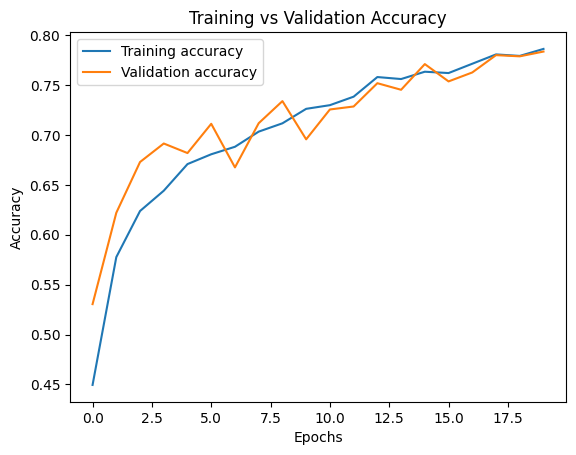

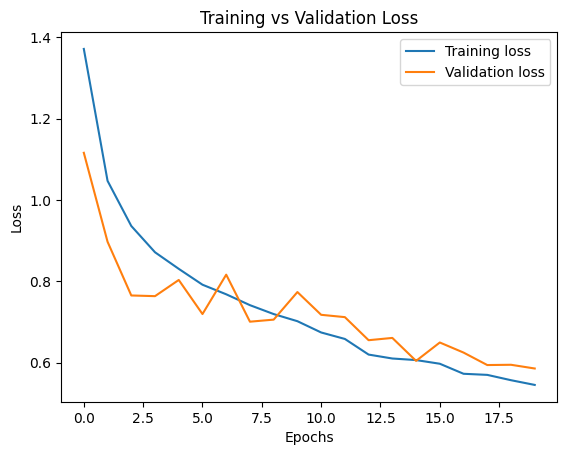

In [7]:
import matplotlib.pyplot as plt

def plot_training_results(history, metrics=["accuracy", "loss"]):
    """
    Plots training and validation metrics for each metric in the list.

    Parameters:
    - history: The history object returned by model.fit().
    - metrics: A list of metric names to plot (e.g., ["accuracy", "loss"]).
    """
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

# Plot accuracy and loss for the initial training
plot_training_results(fine_tune_history, metrics=["accuracy", "loss"])


In [5]:

# Evaluate the Improved Model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")

# Classification report and confusion matrix
val_preds = np.argmax(model.predict(validation_generator), axis=1)
true_labels = validation_generator.classes
print(classification_report(true_labels, val_preds, target_names=validation_generator.class_indices.keys()))
print(confusion_matrix(true_labels, val_preds))
    

53/53 ━━━━━━━━━━━━━━━━━━━━ 2138s 41s/step - AUC: 0.9451 - accuracy: 0.7857 - loss: 0.5943
Validation Loss: 0.59
Validation Accuracy: 0.78
53/53 ━━━━━━━━━━━━━━━━━━━━ 1513s 29s/step
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.28      0.30      0.29       450
      2. Ekzama       0.28      0.30      0.29       450
        3. Akne       0.22      0.21      0.21       322
      4. Malign       0.25      0.23      0.24       450

       accuracy                           0.26      1672
      macro avg       0.26      0.26      0.26      1672
   weighted avg       0.26      0.26      0.26      1672

[[134 117  77 122]
 [128 136  79 107]
 [ 76 104  67  75]
 [137 125  86 102]]


In [6]:

# Improved Feature Extraction for KNN and RF
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

def extract_features(model, generator):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(feature_extractor, train_generator)
val_features, val_labels = extract_features(feature_extractor, validation_generator)

pca = PCA(n_components=128)  # Dimensionality reduction
train_features_pca = pca.fit_transform(train_features)
val_features_pca = pca.transform(val_features)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features_pca, train_labels)
knn_accuracy = accuracy_score(val_labels, knn.predict(val_features_pca))
print(f"KNN Validation Accuracy: {knn_accuracy:.2f}")

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(train_features_pca, train_labels)
rf_accuracy = accuracy_score(val_labels, rf.predict(val_features_pca))
print(f"Random Forest Validation Accuracy: {rf_accuracy:.2f}")
    

188/188 ━━━━━━━━━━━━━━━━━━━━ 894s 5s/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step
KNN Validation Accuracy: 0.26
Random Forest Validation Accuracy: 0.26
